# Notebook structure

- [Approach description](#approach)
  - [Overview](#overview)
  - [Pros and Cons](#pros_cons)
  - [More detailed description of the approach](#details)
- [Common section for all sub-tasks](#common)
- [Outcomes data for COVID-19 after mechanical ventilation adjusted for age](#task1)
  - [results](#results1)
- [Efforts to determine adjunctive and supportive interventions that can improve the clinical outcomes of infected patients (e.g. steroids, high flow oxygen)](#task2)
  - [results](#results2)
- [Best telemedicine practices, barriers and faciitators, and specific actions to remove/expand them within and across state boundaries.](#task3)
  - [results](#results3)
- [Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure – particularly for viral etiologies](#task4)
  - [results](#results4)
- [Model recalculation](#recalculation)


# Approach description <a id="approach"></a>

## Overview <a id="overview"></a>

We will:
- use **LSI** (Latent Semantic Indexing)
- to convert **paragraphs** from papers into fixed-length vectors
- and store them in **ANN** (Approximate Nearest Neighbour) index

Next, we will:
- convert the **query** (task related question) into fixed-length vector using **LSI**
- query the **ANN** index for nearest neighbours
- score the results with **weighted regexp criteria**
- and **highlight** text within top results
- using **color coding** of different aspects of the query

### Example output

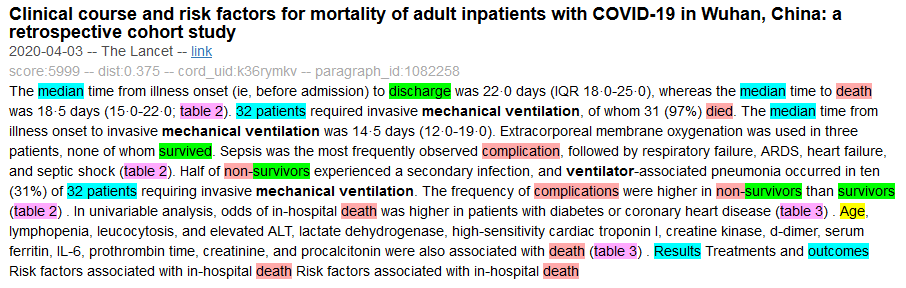

## Pros and Cons <a id="pros_cons"></a>

### Pros

- Coloured highlight enables fast assesment of the paragraph and extraction of key informations
- Displaying full paragraphs in the output (instead of filtered sentences) gives better context and minimizes the risk of ommiting important information
- Natural language queries can be used (although keyword based queries seem to do better)
- Querying the ANN index is fast - it allows rapid testing of various queries / criteria.

### Cons

- Criteria weights require carefull tuning
- Criteria patterns require manual handling of synonymes
- Displaying full paragraphs in the output (instead of filtered sentences) makes analysis of the results more time consuming 

## More detailed description of the approach <a id="details"></a>

The model uses Inverness package which wraps Gensim and NMSLIB.

Model creation steps:
- every json file is converted into collection of documents
- each document represents one paragraph from the paper
- text from the paragraph is tokenized
- tokenized documents are used to create a dictionary
- dictionary is pruned to omit too frequent and too rare words
- tokenized documents and the dictionary are used to create Bag Of Words (BOW) representation of the documents
- documents in BOW formats are used to create TFIDF weighting scheme
- documents in BOW format and TFIDF weights are used to create sparse / variable length vector representation of the documents
- sparse represetation is used to calculate Latant Semantic Indexing (LSI) transformation
- sparse representation and LSI transformation is used to create dense / fixed length vector representation of documents
- dense representation is used to create Approximate Nearest Neighbour (ANN) index that uses HNSW algorithm and uses cosine similarity space

Model query steps:
- natural language or keyword based query is converted into dense / fixed length vector representation 
- ANN index is used to return N nearest documents (using cosine distance)
- each document is scored using weighted regular expressions (called criteria, see helper functions :: score_text docstring)
- documents with the best score are displayed to the user
- selected document fragments are highlighted using different styles
- styles are related to different aspects of the criteria (death related, age related, estimator related, data related etc)


## Other tested approaches

The following methods were tested and found to be subjectively inferior:
- sparse ANN index query (TFIDF weighted BOW - without LSI)
- reverse index query using set of keywords aquired from regexp matching dictionary items to core keywords patterns


# Common section for all sub-tasks <a id="common"></a>

### Instalation of required packages

In [ ]:
!pip install inverness==0.0.3

### Model load

In [ ]:
import inverness
model = inverness.Model('/kaggle/input/cord-19-inverness-all-v7/')
model.load(['fun','meta','phraser','dictionary','tfidf','lsi','dense_ann'])

### Standard imports

In [ ]:
from IPython.core.display import display, HTML
from matplotlib import pyplot as plt
import pandas as pd

from pprint import pprint
from time import time
import re
import os

### Paper metadata

In [ ]:
pd.read_csv('/kaggle/input/CORD-19-research-challenge/metadata.csv',nrows=3) # just a sample

In [ ]:
meta_by_sha = {}
meta_by_pmc = {}

t0 = time()

COLS = ['cord_uid','sha','pmcid','publish_time','journal','url','title','authors']
df = pd.read_csv('/kaggle/input/CORD-19-research-challenge/metadata.csv')
selected = df[df['full_text_file'] != ''][COLS]

rows = selected.iterrows()
for _,r in rows:
    if type(r['title']) is float: r['title']='' # ugly fix for NaN
    if type(r['sha']) is str:
        for sha in r['sha'].split(';'):
            sha = sha.strip()
            meta = {k:r[k] for k in COLS} 
            meta_by_sha[sha] = meta
    if type(r['pmcid']) is str:
            pmc = r['pmcid']
            meta = {k:r[k] for k in COLS} 
            meta_by_pmc[pmc] = meta

print(f"done in {time()-t0:.01f} seconds")

In [ ]:
print("Paper metadata sample:\n")
for sha in meta_by_sha:
    pprint(meta_by_sha[sha])
    break

### Helper functions

In [ ]:
def score_text(text, criteria):
    """score text according to the criteria
    
    criteria - mixed list of regexp patterns (string) and weights (int,float)
               weight creates new group which includes all patterns untill new weight is defined
               if weight is a float then the first digit after the decimal dot specifies
               max count for that group
               
               example: [5,'questlord','inverness', 2,'honour','glory','pride', 1.5,'unicorn']
               
                   group 1 -- weight:5  patterns:questlord,inverness  max_cnt:0 (unlimited) 
                   group 2 -- weight:2  patterns:honour,glory,pride   max_cnt:0 (unlimited)
                   group 3 -- weight:1  patterns:unicorn              max_cnt:5
    """
    total = 0
    value = 1
    max_cnt = 0
    group_cnt = 0
    for c in criteria:
        if type(c) in (int,float):
            value = c
            group_cnt = 0
            max_cnt = round(c%1*10)
        else:
            c = c.replace('_',r'\b')
            matches = re.findall(c,text,re.I)
            cnt = len(matches)
            #if max_cnt: cnt=min(max_cnt,cnt) # option 1: pattern limit
            if max_cnt: cnt=min(max_cnt-group_cnt,cnt);group_cnt+=cnt # option 2: group limit
            score = value*cnt_to_score(cnt)
            total += score
    return total


def cnt_to_score(cnt):
    """transform match count to score"""
    if cnt==0: return 0
    return cnt
    #return min(3,cnt)
    #return 2-1/cnt
    

def score_ann_results(i_d_lists, criteria):
    """score ann query results and """
    results = []
    for i,d in zip(*i_d_lists):
        # metadata
        paper_id = model.meta[i]['paper_id']
        if paper_id in meta_by_sha:
            meta = meta_by_sha[paper_id]
        else:
            meta = meta_by_pmc[paper_id]
        # text
        doc = model.get_doc(i)
        text = model.doc_to_text(doc).replace('\n',' ').replace('\r',' ')
        html = highlight(text, criteria, style_by_group_id, default_style)
        # score
        #score = score_text(text, criteria) + score_text(meta['title'], criteria) # option1: add separate scores
        score = score_text(meta['title']+" :: "+text, criteria) # option2: score combined
        # output
        rec = score,d,i,html,meta
        results += [rec]
    results.sort(key=lambda x:(-x[0],x[1]))
    return results


def score_queries(queries, criteria, K=50):
    """"""
    by_score = []
    for query in queries:
        q = model.text_to_dense(query)
        i_d = model.dense_ann_query(q,K)
        results = score_ann_results(i_d, criteria)
        score = agg_results(results)
        by_score += [(score,query)]
    by_score.sort()
    return by_score


def highlight(text, criteria, styles={}, default='w=bold'):
    """"""
    group_id = 0
    for c in criteria:
        if type(c) in (int,float):
            group_id += 1
        else:
            c = c.replace('_',r'\b')
            c = f'({c}\\w*)'
            style = styles.get(group_id,default)
            style_props = []
            for prop in style.split(','):
                k,_,v = prop.partition('=')
                if k=='w':
                    style_props += [f'font-weight:{v}']
                if k=='fg':
                    style_props += [f'color:{v}']
                if k=='bg':
                    style_props += [f'background-color:{v}']
            before = f'<span style="{";".join(style_props)}">'
            after = '</span>'
            text = re.sub(c, before+'\\1'+after, text, flags=re.I)
            # TODO default
    return text


# L2 score
def agg_results(results):
    """"""
    scores = [x[0] for x in results]
    return sum([x*x for x in scores])**0.5


# TODO break title into multiple lines
def plot_results(results,title=''):
    """"""
    scores = [x[0] for x in results]
    scores.sort(reverse=True)
    plt.plot(scores)
    if title: plt.title(title)
    score = agg_results(results)
    plt.xlabel('rank')
    plt.ylabel('score')
    plt.figtext(0.4, 1, f"total L2 score: {score:.02f}")
    plt.show()

def display_result(result): 
    score,dist,i,html,meta = result
    display(HTML(f"""
            <h3>{meta['title']}</h3>
            <p>
                {meta['publish_time']} -- 
                {meta['journal']} -- 
                <a href="{meta['url']}">link</a>
            </p>
            <p style="color:#AAAAAA">
                score:{score:.0f} --
                dist:{dist:.03f} --
                cord_uid:{meta['cord_uid']} -- 
                paragraph_id:{i}
            </p>
            {html}
        """))


# <a id="task1"></a> Outcomes data for COVID-19 after mechanical ventilation adjusted for age

## Scoring criteria

We will use weighted regular expressions (regexp) grouped by various aspects of the query.


We will **highlight** different aspects of the query using following color codes:
- **green** - positive outcome
- **red** - negative outcome
- **amber** - estimator
- **yellow** - age related
- **cyan** - outcome / result
- **magenta** - table / chart / figure
- **bold** - core keyword


In [ ]:
# criteria format explained in "helper functions :: score_text docstring"

criteria = [
    # group 1: core keywords
    1000.2,'mechanic\w+ ventilat\w+',
    
    # group 2: age related 
    100.5,'adjust','_age\w?_','_years','_old',   'elder','young',

    # group 3: negative outcomes
    20.5,'nonsurviv','non-surviv','_died','dead','death','mortality','complication',
    
    # group 4: positive outcomes
    2,'_surviv','discharge','extubate','alive',
    
    # group 5: estimator
    10,'Kaplan.Meier','APACHE','SOFA','RIFLE','Glasgow.Coma','GCS','SAPS',
       '_RESP_','RSBI','1000.person_',
    
    # group 6: generic data related keywords
    50.1,'figure \d+','_fig[.]\s*\d+','_table \d+',
    
    # group 7: data related keywords
    2,'outcome','result','cohort','median','_n\s*=\s*\d+',
      '(?<=[ (])\d+ (?:patients|cases|men|women)',
    
    # group 8: covid-19
    5000.1,'covid|sars-cov|cov-2|cov2'
]

style_by_group_id = {
    1:'bg=#DDDDDD,w=bold', # grey
    2:'bg=#FFFF00', # yellow
    3:'bg=#FFAAAA', # red
    4:'bg=#00FF00', # green
    5:'bg=#FFCC00', # amber
    6:'bg=#FFAAFF', # magenta
    7:'bg=#00FFFF', # cyan
    8:'fg=#FF0000,w=bold'
}
default_style = ''

## Query selection

Although we can query our model using verbatim task questions, we should compare the results with the results of a keyword-based query.

We will score different queries (including verbatim task question) using criteria defined above.

For each query we:
- fetch K=50 paragraphs closest to the query (using ANN)
- score each paragraph using scoring criteria (regexps and weights)
- calculate aggregate score for the query (L2 measure)

In [ ]:
K = 50
queries = [
        'Outcomes data for COVID-19 after mechanical ventilation adjusted for age',   
        'Results for COVID-19 after mechanical ventilation adjusted for age',
        'COVID-19 results after mechnical ventilation discharged dead died',
        'COVID-19 results after mechnical ventilation discharged dead died survived survivors adjusted age years old',
        'COVID-19 results after mechnical ventilation discharged died survived survivors extubated adjusted',
        'COVID-19 results after mechnical ventilation discharged dead died survived survivors adjusted age years old',
        'COVID-19 results after mechnical ventilation discharged died survived extubated adjusted',
        'COVID-19 results after mechnical ventilation discharged died survived extubated adjusted age',
        'COVID-19 outcomes after mechnical ventilation discharged died survived extubated adjusted',
        'COVID-19 results outcomes after mechnical ventilation discharged died survived extubated adjusted age',
        'COVID-19 results outcomes after mechnical ventilation discharged died survived extubated',
        'COVID-19 results outcomes mechnical ventilation discharged died survived extubated',
        'COVID-19 results outcomes after mechnical ventilation discharged died survived extubated adjusted',
        'Covid-19 results outcomes after mechnical ventilation discharged died survived extubated adjusted',
        'COVID-19 covid-19 results outcomes after mechnical ventilation discharged died survived extubated adjusted',
        'COVID-19 results outcomes after mechnical ventilation discharged died survived extubated adjusted',
        'COVID-19 results outcmes data after mechnical ventilation discharged died survived extubated adjusted age',
        'COVID-19 results outcomes mechnical ventilation discharged died survived',
        'COVID-19 results outcomes mechnical ventilation discharged died survived age',
        'COVID-19 results outcomes mechnical ventilation discharged died survived age old',
        'COVID-19 results outcomes mechnical ventilation discharged died survived adjusted age',
        'COVID-19 results outcomes mechnical ventilation discharged died survived adjusted age old',
        'COVID-19 results outcomes mechnical ventilation died survived',
        'COVID-19 results outcomes mechnical ventilation died survived age',
        'COVID-19 results outcomes mechnical ventilation died survived adjust age',
        'COVID-19 results outcomes mechnical ventilation died survived adjusted age',
]

for score,query in score_queries(queries, criteria, K):
    print(f"{score:10.02f} -- {query}")


## Final Query

In [ ]:
#query = 'Outcomes data for COVID-19 / SARS-CoV-2 after mechanical ventilation adjusted for age'
#query = 'Outcomes data for COVID-19 after mechanical ventilation adjusted for age'
query = "COVID-19 results outcomes mechnical ventilation died survived"
#query = "Best telemedicine practices, barriers and faciitators, and specific actions to remove/expand them within and across state boundaries"
K = 500

q = model.text_to_dense(query)
ann_results = model.dense_ann_query(q, K)
results = score_ann_results(ann_results, criteria)
plot_results(results, title='Query result score by rank (descencing scores)')


## <a id="results1"></a> Results

In [ ]:
N = 20
for result in results[:N]:
    display_result(result)

# <a id="task2"></a> Efforts to determine adjunctive and supportive interventions that can improve the clinical outcomes of infected patients (e.g. steroids, high flow oxygen)

## Scoring criteria

In [ ]:
# criteria format explained in "helper functions :: score_text docstring"

criteria = [
    # group 1: core keywords
    1000.3,'adjunct','supportive','adjuvant',
    
    # group 2: specific treatments
    200.5,'corticosteroid','steroid','high.flow','supplement','oxygen','_hormon','pharmac','antibiotic',
    
    # group 3: not used
    0,
    
    # group 4: intervention
    50.5,
        'intervention',
        'treatment',
        'treating',
        'therapy',   
        'care',

    # group 5: not used
    10.5,
        "effectiv","impact","_reduc","measure",
    
    # group 6: generic data related keywords
    50.1,'figure \d+','_fig[.]\s*\d+','_table \d+',
    
    # group 7: data related keywords
    2,'outcome','result','cohort','median','_n\s*=\s*\d+',
      '(?<=[ (])\d+ (?:patients|cases|men|women)',
    
    # group 8: covid-19
    5000.1,'covid|sars-cov|cov-2|cov2'
]

style_by_group_id = {
    1:'bg=#DDDDDD,w=bold', # grey
    2:'bg=#FFFF00', # yellow
    3:'bg=#FFAAAA', # red
    4:'bg=#00FF00', # green
    5:'bg=#FFCC00', # amber
    6:'bg=#FFAAFF', # magenta
    7:'bg=#00FFFF', # cyan
    8:'fg=#FF0000,w=bold'
}
default_style = ''

## Query selection

In [ ]:
K = 50
queries = [
    "Efforts to determine adjunctive and supportive interventions that can improve the clinical outcomes of infected patients (e.g. steroids, high flow oxygen)",
    "COVID-19 Efforts to determine adjunctive and supportive interventions that can improve the clinical outcomes of infected patients (e.g. steroids, high flow oxygen)",
    "COVID-19 Efforts to determine adjunctive and supportive intervention that can improve the clinical outcomes of infected patients (e.g. steroids, high flow oxygen)",
    "COVID-19 adjunctive supportive adjuvant",
    "COVID-19 adjunctive supportive adjuvant therapy intervention",
    "COVID-19 adjunctive supportive adjuvant therapy interventions",
    "COVID-19 adjunctive supportive adjuvant intervention",
    "COVID-19 adjunctive supportive adjuvant therapy intervention treatment",
    "COVID-19 adjunctive supportive adjuvant therapy intervention steroids",
    "COVID-19 adjunctive supportive adjuvant therapy intervention steroid",
    "COVID-19 adjunctive supportive adjuvant therapy intervention high flow oxygen",
    "COVID-19 adjunctive supportive adjuvant therapy intervention high flow oxygen corticosteroids",
    "COVID-19 adjunctive supportive adjuvant therapy intervention corticosteroids",
    "COVID-19 adjunctive supportive adjuvant therapy intervention high-flow oxygen",
    "COVID-19 adjunctive supportive adjuvant high-flow",
    "COVID-19 adjunctive supportive adjuvant high-flow steroid",
    "COVID-19 adjunctive supportive adjuvant high-flow steroids",
    "COVID-19 adjunctive supportive adjuvant high-flow corticosteroids",
    "COVID-19 adjunctive supportive adjuvant therapy intervention treatment high-flow",
    "COVID-19 adjunctive supportive adjuvant high-flow oxygen corticosteroids",
    'COVID-19 adjunctive supportive adjuvant intervention high flow oxygen care',
    'COVID-19 adjunctive supportive adjuvant adjunct therapy intervention high-flow oxygen',
    'SARS-CoV-2 COVID-19 adjunctive supportive adjuvant adjunct therapy intervention high-flow oxygen',
    'SARS-CoV-2 adjunctive supportive adjuvant adjunct therapy intervention high-flow oxygen',
    "SARS-CoV-2 COVID-19 adjunctive supportive adjuvant",
    "SARS-CoV-2 adjunctive supportive adjuvant",
]

for score,query in score_queries(queries, criteria, K):
    print(f"{score:10.02f} -- {query}")

## Final Query

In [ ]:
#query = "COVID-19 adjunctive supportive adjuvant high-flow oxygen corticosteroids"
#query = "COVID-19 adjunctive supportive adjuvant therapy intervention"
#query = "COVID-19 adjunctive supportive adjuvant high-flow"
#query = "COVID-19 adjunctive supportive adjuvant therapy intervention high flow oxygen"
query = "COVID-19 adjunctive supportive adjuvant adjunct therapy intervention high-flow oxygen"
K = 500

q = model.text_to_dense(query)
ann_results = model.dense_ann_query(q, K)
results = score_ann_results(ann_results, criteria)
plot_results(results, title='Query result score by rank (descencing scores)')

## <a id="results2"></a> Results

In [ ]:
N = 20
for result in results[:N]:
    display_result(result)

# <a id='task3'></a> Best telemedicine practices, barriers and faciitators, and specific actions to remove/expand them within and across state boundaries.

## Scoring Criteria

In [ ]:
# criteria format explained in "helper functions :: score_text docstring"

criteria = [
    # group 1: core keywords
    1000.3,'tele-','tele','_remot',
    
    # group 2: technology related
    200.5, 'video','conferenc','collabor','_web_','_web-','smartphone','_call',
           'wearable','cyber','electronic','cell phone','network','internet',
    
    # group 3: not used
    0,
    
    # group 4: not used
    50.5,


    # group 5: not used
    10.5,
    
    # group 6: generic data related keywords
    50.1,'figure \d+','_fig[.]\s*\d+','_table \d+',
    
    # group 7: not used
    2,
    
    # group 8: covid-19
    2000.1,'covid|sars-cov|cov-2|cov2'
]

style_by_group_id = {
    1:'bg=#DDDDDD,w=bold', # grey
    2:'bg=#FFFF00', # yellow
    3:'bg=#FFAAAA', # red
    4:'bg=#00FF00', # green
    5:'bg=#FFCC00', # amber
    6:'bg=#FFAAFF', # magenta
    7:'bg=#00FFFF', # cyan
    8:'fg=#FF0000,w=bold'
}
default_style = ''

## Query selection

In [ ]:
K = 50
queries = [
    "Best telemedicine practices, barriers and faciitators, and specific actions to remove/expand them within and across state boundaries",
    'telemedicine',
    'tele telemedicine',
    'telemedicine remote access',
    'telemedicine remotely',
    'telephone',
    'telephone telehealth telemedicine',
    'telephone telemedicine',
    'telephone telehealth',
    'telehealth',
    'homecare',
    'telemedicine homecare',
    'telemedicine telehealth homecare',
    'telemedicine telehealth homecare teletriage',
    'teletriage',
    'telemedicine remotely telehealth homecare',
    'telemedicine remotely web-based',
    'telemedicine remotely web',
    'telemedicine remotely collaborative',
    'teleconsultation',
    'remotely',
]

for score,query in score_queries(queries, criteria, K):
    print(f"{score:10.02f} -- {query}")

# telephone gives good score but bad results

## Final query

In [ ]:
#query = "telemedicine"
#query = "telemedicine telehealth homecare"
query = "telemedicine remotely"
K = 1500

q = model.text_to_dense(query)
ann_results = model.dense_ann_query(q, K)
results = score_ann_results(ann_results, criteria)
plot_results(results, title='Query result score by rank (descencing scores)')

## <a id="results3"></a> Results

In [ ]:
N = 20
for result in results[:N]:
    display_result(result)

# <a id="task4"></a> Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure – particularly for viral etiologies

## Scoring criteria

In [ ]:
# criteria format explained in "helper functions :: score_text docstring"

criteria = [
    # group 1: core keywords
    1000.4,'ARDS','etiolog',
    
    # group 2: age related 
    100.4,'adjust','_age\w?_','_years','_old',   'elder','young',

    # group 3: negative outcomes
    500.5,'nonsurviv','non-surviv','_died','dead','death','mortality',

    # group 4:
    0,
    
    # group 5: 
    100.3,'organ','failure','dysfunction',
    
    # group 6: generic data related keywords
    50.1,'figure \d+','_fig[.]\s*\d+','_table \d+',
    
    # group 7: data related keywords
    2,'outcome','result','cohort','median','_n\s*=\s*\d+',
      '(?<=[ (])\d+ (?:patients|cases|men|women)',
    
    # group 8: covid-19
    1000.1,'covid|sars-cov|cov-2|cov2'
]

style_by_group_id = {
    1:'bg=#DDDDDD,w=bold', # grey
    2:'bg=#FFFF00', # yellow
    3:'bg=#FFAAAA', # red
    4:'bg=#00FF00', # green
    5:'bg=#FFCC00', # amber
    6:'bg=#FFAAFF', # magenta
    7:'bg=#00FFFF', # cyan
    8:'fg=#FF0000,w=bold'
}
default_style = ''

## Query selection

In [ ]:
K = 50
queries = [
    "Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure – particularly for viral etiologies",
    "COVID-19 Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure – particularly for viral etiologies",
    "COVID-19 ARDS failure etiology etiologies",
    "COVID-19 ARDS failure etiology",
    "COVID-19 ARDS failure etiologies",
    "COVID-19 ARDS organ failure etiology etiologies",
    "COVID-19 ARDS organ failure etiology",
    "COVID-19 ARDS organ failure etiologies",
    "ARDS failure etiology etiologies",
    "ARDS failure etiology",
    "ARDS failure etiologies",
    "ARDS organ failure etiology etiologies",
    "ARDS organ failure etiology",
    "ARDS organ failure etiologies",
    "ARDS organ failure virus etiologies",
    "ARDS organ failure viral etiologies",
    "ARDS organ failure etiologies died survived",
    "ARDS organ failure mortality",
    "ARDS mortality",
]

for score,query in score_queries(queries, criteria, K):
    print(f"{score:10.02f} -- {query}")

## Final Query

In [ ]:
#query = "Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure – particularly for viral etiologies"
#query = "COVID-19 Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure – particularly for viral etiologies"
#query = "ARDS failure etiology"
query = "ARDS mortality"
K = 500

q = model.text_to_dense(query)
ann_results = model.dense_ann_query(q, K)
results = score_ann_results(ann_results, criteria)
plot_results(results, title='Query result score by rank (descencing scores)')

## <a id="results4"></a> Results

In [ ]:
N = 20
for result in results[:N]:
    display_result(result)

# Model recalculation <a id="recalculation"></a>

By default this notebook **will not** recalculate the model - it uses precalculated model loaded from disk (additional dataset defined in the notebook). To recalculate the model variable "do_recalc" must be set to True.


By default only 100 papers will be used in recalculation as full model recalculation will take several hours. To recalculate the model using all the papers the "papers_limit" variable must be set to None.

**!!! IMPORTANT !!!** After 2020-03-27 input dataset update recalculating the model for all the papers is impossible on kaggle - depending on the model storage settings we exceed HDD or RAM quota :( The model imported at the begining of this notebook was precalculated on the PC.


### Core options

In [ ]:
do_recalc = False

# Number of json files to read
# Setting this variable to None will read all files
papers_limit = 100

# Number of worker processes for calculation of sparse and dense vectors
workers = 1

# Memory/disk tradeoff controls
# 
# Possible values:
#
#   disk - data is stored only on disk, index is stored in memory
#          slower access BUT multiprocesing is possible (workers>1)
#          requires little RAM but alot of DISK
#
#   mem - data is stored in memory
#         faster access and fast recalculation time
#         requires alot of DISK and RAM
#
#   mem_only - data is stored in memory, data is not persisted when calling .save()
#              faster access and fastest recalculation time
#              BUT data will not be saved on disk
#              requires little DISK but alot of RAM
#
# when workers>1 all values are asummed to be 'disk'
meta_storage   = 'disk'
bow_storage    = 'mem_only'
sparse_storage = 'mem_only'
dense_storage  = 'mem_only'


### Data access functions

In [ ]:
# ---[ list ]-------------------------------------------------------------------

import os

def list_data_files():
    """iterate over paths of all data files"""
    for dirpath,_,filenames in os.walk('/kaggle/input/CORD-19-research-challenge/'):
        filenames = [f for f in filenames if f.endswith('.json')]
        if not filenames: continue
        for f in filenames:
            yield os.path.join(dirpath,f)

# ---[ convert ]----------------------------------------------------------------

import json

def json_to_docs(path):
    """iterate over paragraph level documents from one json document"""
    paper = json.load(open(path,'rb'))
    # parts
    text_id = 0
    for part in ['abstract','body_text']:
        if part not in paper: continue
        for x in paper[part]:
            doc = {}
            # metadata
            doc['paper_id'] = paper['paper_id']
            doc['paper_title'] = paper['metadata']['title']
            doc['path'] = path
            doc['part'] = part
            text_id += 1
            doc['text_id'] = text_id
            #
            doc['text'] = x['text']
            doc['section'] = x['section']
            # bib
            doc['bib_titles'] = []
            for ref in x['cite_spans']:
                ref_id = ref['ref_id']
                if not ref_id: continue 
                ref_title = paper['bib_entries'][ref_id]['title'] # ERROR
                doc['bib_titles'] += [ref_title]
            # ref (tables and figures)
            doc['tables'] = []
            doc['figures'] = []
            for ref in x['ref_spans']:
                ref_id = ref['ref_id']
                if not ref_id: continue
                r = paper['ref_entries'][ref_id] # ERROR
                if r['type']=='table':
                    doc['tables'] += [r['text']]
                if r['type']=='figure':
                    doc['figures'] += [r['text']]
            yield doc

def doc_iter(limit=None):
    """iterate over all documents (doc = single paragraph)"""
    from itertools import islice
    for path in islice(list_data_files(),limit):
        yield from json_to_docs(path)

def get_doc(path,text_id):
    """get single document (paragraph)"""
    docs = json_to_docs(path)
    for doc in docs:
        if doc['text_id']==text_id:
            return doc


### Model configuration

In [ ]:
import numpy as np

prune_cfg = {
    'no_below': 2,
    'no_above': 0.50,
    'keep_tokens': ['<PAD>','<DNA>'],
    'stopwords': [],
}

tfidf_cfg = {'smartirs':'ltu'}

lsi_cfg = {
    'num_topics': 100,
    'dtype': np.single,
    'onepass': False,
}


def doc_to_text(doc):
    values = [
            doc['text'],
            doc['section'],
            '\n'.join(doc['tables']),
            '\n'.join(doc['figures']),
            '\n'.join(doc['bib_titles'])
        ]
    return '\n'.join(values)


def get_meta(id,doc):
    m = {f:doc[f] for f in ['paper_id','text_id','path']}
    m['id'] = id # DEBUG
    return m


def get_doc_by_meta(meta):
    path = meta['path']
    text_id = meta['text_id']
    return get_doc(path,text_id)

# ------------------------------------------------------------------------------

import re

split_tokens_re = re.compile('[\s.,;!?()\[\]]+')
upper_re = re.compile('[A-Z]')
num_re = re.compile('\d+|\d+[%]|\d+[a-z]|[#]\d+|[~]\d+')
url_re = re.compile('[hH][tT][tT][pP][sS]?://[a-zA-Z._0-9/=&?,|%-]+')
dna_re = re.compile('[AGCT]{8,}')

def text_to_tokens(text):
    text = url_re.sub('<URL>',text)
    tokens = split_tokens_re.split(text)
    tokens = [t.lower() if len(t)>1 and len(upper_re.findall(t))<2 else t for t in tokens]
    tokens = ['<NUM>' if num_re.match(t) else t for t in tokens]
    tokens = ['<DNA>' if dna_re.match(t) else t for t in tokens]
    return tokens


### Model recalculation

In [ ]:
from pprint import pprint
from itertools import islice
from time import time
import inverness

if do_recalc:
    t0 = time()
    
    label = papers_limit or 'all'
    model = inverness.Model(f'model_{label}_v7/')

    model.text_to_tokens = text_to_tokens
    model.doc_to_text = doc_to_text
    model.get_doc_by_meta = get_doc_by_meta
    model.doc_iter = lambda:doc_iter(papers_limit)
    model.get_meta = get_meta
    model.init_fun()
    #
    model.init_meta(storage='disk' if workers>1 else meta_storage)
    model.skip_phraser()
    model.skip_phrased()
    model.init_dictionary()
    model.prune_dictionary(**prune_cfg)

    if workers<=1:
        model.init_bow(storage=bow_storage)
        model.phrased.delete() # del
        model.init_tfidf(**tfidf_cfg)
        model.init_sparse(storage=sparse_storage)
        model.bow.delete() # del
        model.init_lsi(**lsi_cfg)
        model.init_dense(storage=dense_storage)
    else:
        model.init_bow(storage='disk')
        model.phrased.delete() # del
        model.init_tfidf(**tfidf_cfg)
        model.init_sparse_mp(workers)
        model.bow.delete() # del
        model.init_lsi(**lsi_cfg)
        model.init_dense_mp(workers)

    model.sparse.delete() # del
    model.init_dense_ann(post=2)
    model.dense.delete() # del
    
    print(f'\n\ntotal: {time()-t0:.01f}s\n\n')


### Model health check

We can check health of the model by trying to find random documents by their content.

If the document occurs within top k=1 results we count this as a success.

We repeat this process N=100 times and average the score.

In [ ]:
N = 100
k = 1

def test_model(ids,fun,k=1):
    ok_cnt = 0
    for i in ids:
        m = model.meta[i]
        query = model.doc_to_text(model.get_doc_by_meta(m))
        top = list(fun(query))[:k] # id,score,m
        top_ids = [x[0] for x in top]
        if i in top_ids:
            ok_cnt += 1
    return ok_cnt / len(ids)

from random import randint
ids = [randint(0,len(model.meta)-1) for _ in range(N)]
score = test_model(ids, model.find_dense, k)
print(f'find_dense_score: {score:.03f}\ndocuments: {len(model.meta)}')
